In [1]:
from train import train
from inference import inference
from save_mask import save_mask
import csv, os
from utils.module import write_to_csv

In [2]:
!nvidia-smi

Wed Nov  8 00:45:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla M60                      On  | 00000000:00:1B.0 Off |                    0 |
| N/A   28C    P8              15W / 150W |      0MiB /  7680MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Uncertainty-based Self-Training
project = "231107"
folnames = [project+"_iter1", project+"_iter2", project+"_iter3", project+"_iter4", project+"_iter5"]
os.makedirs('results/'+ project +'_results', exist_ok=True)
csv_filename = 'results/'+project+'_results/results.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Iteration', 'F1-Score', 'Accuracy', 'Specificity', 'Recall', 'Precision'])

for i in range(len(folnames)):
    if i==0:
        # train(former_folname="hoge", folname=folnames[i], first=True, net="deeplab", epochs=300, batch_size=64)
        scores = inference(former_folname="hoge", folname=folnames[i], net="deeplab", batch_size=64)
        write_to_csv(i+1, scores, csv_filename)
        save_mask(former_folname="hoge", folname=folnames[i], net="deeplab", batch_size=64)
    else:
        train(former_folname=folnames[i-1], folname=folnames[i], first=False, net="deeplab", epochs=300, batch_size=64, alpha=100)
        scores = inference(former_folname=folnames[i-1], folname=folnames[i], net="deeplab", batch_size=64)
        write_to_csv(i+1, scores, csv_filename)
        save_mask(former_folname=folnames[i-1], folname=folnames[i], net="deeplab", batch_size=64)

In [ ]:
# Supervised Learning
project = "2310272"
folname = project + '_iter1'
os.makedirs('results/'+ project +'_results', exist_ok=True)
csv_filename = 'results/'+project+'_results/results.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Iteration', 'F1-Score', 'Accuracy', 'Specificity', 'Recall', 'Precision'])

# train(former_folname="hoge", folname=folname, first=True, net="deeplab", epochs=1000, batch_size=64, supervised=True)
scores = inference(former_folname="hoge", folname=folname, net="deeplab", batch_size=64, supervised=True)
write_to_csv(1, scores, csv_filename)

In [ ]:
import random

# ランダムな並びの情報を保存
shuffle_indices = list(range(5292))
random.shuffle(shuffle_indices)

# shuffle_indicesをファイルに保存するなど、情報を保存する方法を選びます
with open("shuffle_indices.txt", "w") as file:
    file.write(" ".join(map(str, shuffle_indices)))

In [ ]:
meanlst = os.listdir("data/unlabeled_mask/231021_iter1/pred_mean_corrected/")
varlst = os.listdir("data/unlabeled_mask/231021_iter1/pred_var/")
print(len(meanlst))
print(len(varlst))

In [ ]:
import numpy as np
from PIL import Image
meanlst = os.listdir("data/unlabeled_mask/231021_iter1/pred_mean_corrected/")
varlst = os.listdir("data/unlabeled_mask/231021_iter1/pred_var/")

# # 各画像を処理
for file_name in meanlst:
    file_path = os.path.join("data/unlabeled_mask/231021_iter1/pred_mean_corrected", file_name)
    
    # 画像をnumpy配列に読み込む
    img = np.array(Image.open(file_path))
    
    # 画像サイズが256x256でない場合、警告を表示
    if img.shape != (256, 256):
        print(f"異なるサイズの画像: {file_name}, サイズ: {img.shape}")

In [ ]:
import os
import torch

# フォルダのパス
folder_path = "data/unlabeled_mask/231021_iter1/pred_var/"

# フォルダ内の全ての.ptファイルをリストアップ
pt_files = [f for f in os.listdir(folder_path) if f.endswith(".pt")]

# 各ファイルを処理
for file_name in pt_files:
    file_path = os.path.join(folder_path, file_name)
    
    # PyTorch tensorを読み込む
    tensor = torch.load(file_path)
    
    # 配列サイズが(256, 256)でない場合、警告を表示
    if tensor.size() != torch.Size([256, 256]):
        print(f"異なるサイズのPyTorch tensor: {file_name}, サイズ: {tensor.size()}")


In [5]:
import torch
import glob

fol_name = "231107_iter3"

# pred_varを全て読み込み、torch.meanとtorch.maxの平均を計算する
pred_var_path = sorted(glob.glob(f'data/unlabeled_mask/{fol_name}/pred_var/*'))
mean_box = []
max_box = []

for file in pred_var_path:
    pred_var = torch.load(file)
    mean_box.append(torch.mean(pred_var).item())
    max_box.append(torch.max(pred_var).item())

print(sum(mean_box)/len(mean_box))
print(sum(max_box)/len(max_box))

4.9048204533103916e-05
0.04336320517044685


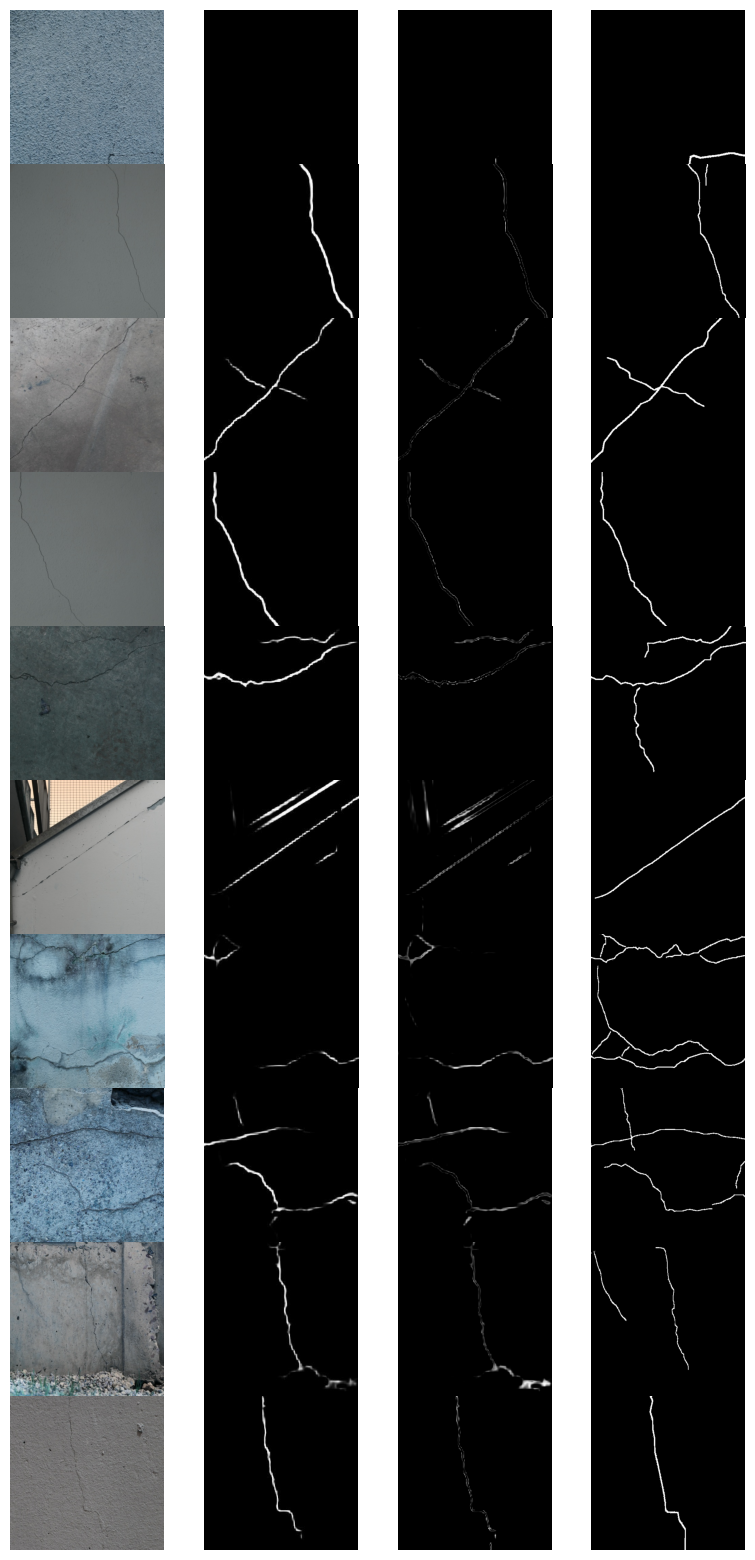

In [15]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image
# Targetデータでの出力を表示
target_filepaths = glob.glob("data/Train/images/Rissbilder*")
target_filenames = [p.lstrip("data/Train/images/") for p in target_filepaths]


# 10行4列のサブプロットを作成
fig, axes = plt.subplots(10, 4, figsize=(10, 20))

# 画像をサブプロットに配置
for i in range(10):
    axes[i, 0].imshow(Image.open("data/Train/images/"+target_filenames[i]))
    axes[i, 0].axis('off')
    axes[i, 1].imshow(Image.open("data/unlabeled_mask/231107_iter1/pred_mean_corrected/"+target_filenames[i]), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(torch.load("data/unlabeled_mask/231107_iter1/pred_var/"+target_filenames[i].rstrip('jpg')+"pt"), cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 3].imshow(Image.open("data/Train/masks/"+target_filenames[i]))
    axes[i, 3].axis('off')

# グリッドの余白を調整
plt.subplots_adjust(wspace=0, hspace=0)

# グリッドを表示
plt.show()

# Train/images/Rissbilder/ pred_mean_corrected, pred_var, Train/masks/Rissbilder